In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import os
from google.colab import drive
from google.colab import auth
from google.auth import default

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch')

Mounted at /content/drive/


Set Up Paths

In [ ]:
from re import A
DATA_ROOT = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/raw")
AQUA_IMGDIR = DATA_ROOT  / "aquavplant" / "img"
AQUA_MSKDIR = DATA_ROOT / "aquavplant" / "mask"
BANGLA_DIR = DATA_ROOT / "bangladesh" / "augmented"
BANGLA_ORIGINAL = DATA_ROOT / "bangladesh" / "original"

# Quick verification
print("Folders found:")
print("1. AquavPlant images:", AQUA_IMGDIR.exists())
print("2. AquavPlant masks:", AQUA_MSKDIR.exists())
print("3. Bangladesh augmented:", BANGLA_DIR.exists())

Folders found:
1. AquavPlant images: True
2. AquavPlant masks: True
3. Bangladesh augmented: True


Build Image-Mask Pairs for AqUavPlant

AqUavPlant: 206 images, 206 matched pairs, 0 missing masks


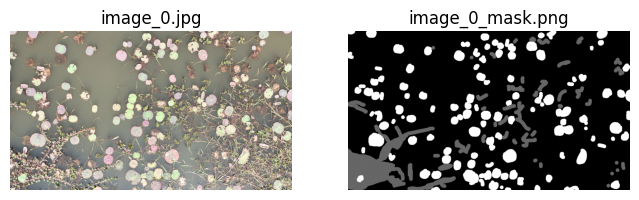

In [ ]:
# image name pattern: image_0.jpg ; mask pattern: image_0_mask.png
img_files = sorted(list(AQUA_IMGDIR.glob("image_*.jpg")))
pairs = []
missing_masks = []

for img_p in img_files:
  stem = img_p.stem
  mask_name = stem + "_mask.png"
  msk_p = AQUA_MSKDIR /mask_name
  if msk_p.exists():
    pairs.append((img_p, msk_p))
  else:
    missing_masks.append((img_p, msk_p))

print(f"AqUavPlant: {len(img_files)} images, {len(pairs)} matched pairs, {len(missing_masks)} missing masks")

# show first valid pair
if pairs:
  sample_img, sample_msk = pairs[0]
  img = Image.open(sample_img).convert("RGB")
  msk = Image.open(sample_msk).convert("L")

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.axis("off")
  plt.title(sample_img.name)

  plt.subplot(1, 2, 2)
  plt.imshow(msk, cmap="gray")
  plt.axis("off")
  plt.title(sample_msk.name)

  plt.show()
else:
  print("No valid pairs found. Check filenames and folders")

Quick Glance at Bangladesh Augmented Data (one sample per species)

1. Common Duckweeds (Lemna minor)
2. Common Water Hyacinth (Eichornia crassipes)
3. Water Lettuce (Pistia stratiotes)
4. Heartleaf False Pickerelweed (Monochoria korsakowii)


<function matplotlib.pyplot.show(close=None, block=None)>

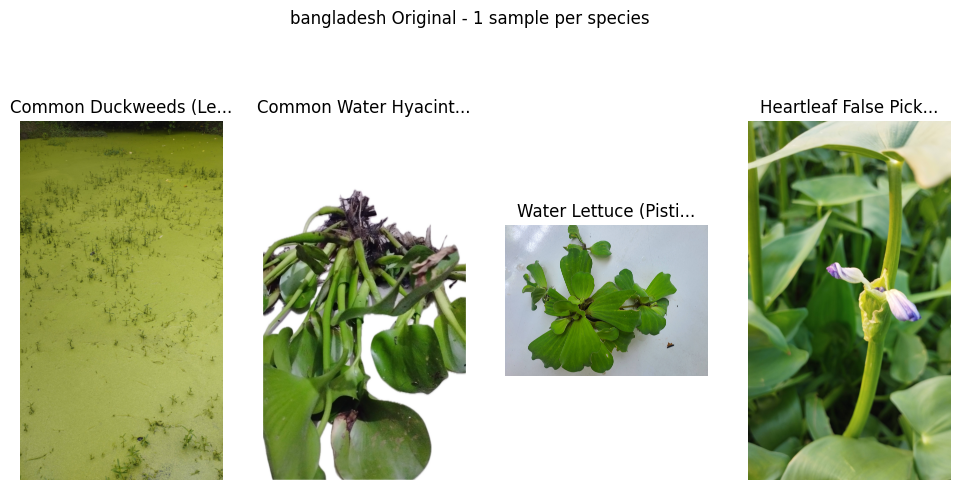

In [ ]:
species_dirs = [d for d in BANGLA_ORIGINAL.iterdir() if d.is_dir()]
species_names = [d.name for d in species_dirs]

for i, name in enumerate(species_names):
  print(f"{i+1}. {name}")

plt.figure(figsize=(12, 6))
for i, species in enumerate(species_dirs):
  # robustly find an image with common extensions
  exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG")
  found = []
  for e in exts:
    found += list(species.glob(e))

  if not found:
    continue
  img = Image.open(found[0]).convert("RGB")
  plt.subplot(1, 4, i+1)
  plt.imshow(img)
  plt.axis("off")
  plt.title(species.name[:20]+"...")

plt.suptitle("bangladesh Original - 1 sample per species")
plt.show

In [ ]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import shutil

In [ ]:
# Paths
DATA_ROOT = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data")
RAW_AQUA_IMG = DATA_ROOT / "raw/aquavplant/img"
RAW_AQUA_MSK = DATA_ROOT / "raw/aquavplant/mask"
RAW_BD_AUG   = DATA_ROOT / "raw/bangladesh/augmented"

INT_AQUA     = DATA_ROOT / "interim/aquavplant"
INT_BD_AUG   = DATA_ROOT / "interim/bangladesh_augmented"

# normalization params
SIZE = 512
IMG_EXT = ".jpg"
MSK_EXT = ".png"

In [2]:
def ensure_dir(p: Path):
  p.mkdir(parents=True, exist_ok=True)

def to_square(img: Image.Image, size=512, is_mask=False) -> Image.Image:
  # resize to a fixed quare while preserving aspect ratio by padding
  resample = Image.NEAREST if is_mask else Image.BILINEAR

  # calculate the new size while preserving aspect ratio
  original_width, original_height = img.size
  ratio = min(size / original_width, size / original_height)
  new_width = int(original_width * ratio)
  new_height = int(original_height * ratio)

  resized_img = img.resize((new_width, new_height), resample=resample)

  # create a new square image with padding
  if is_mask:
      # For masks, use a black background (0)
      square_img = Image.new(resized_img.mode, (size, size), 0)
  else:
      # For images, use a white background (255, 255, 255) or a grey background
      # Using a grey background (128, 128, 128) is common
      square_img = Image.new(resized_img.mode, (size, size), (128, 128, 128))


  # calculate the position to paste the resized image
  paste_x = (size - new_width) // 2
  paste_y = (size - new_height) // 2

  square_img.paste(resized_img, (paste_x, paste_y))

  return square_img


def binarize_mask(msk: Image.Image) -> Image.Image:
  arr = np.array(msk.convert("L"))
  # Convert to np.uint8 which is supported by PIL.Image.fromarray
  bin_ = ((arr > 0).astype(np.uint8)) * 255
  return Image.fromarray(bin_)

Normalize AqUavPlant

In [ ]:
ensure_dir(INT_AQUA)
pairs = []
missing = 0

img_files = sorted(RAW_AQUA_IMG.glob("image_*.jpg"))
for img_p in img_files:
  stem = img_p.stem
  mask_name = stem + "_mask.png"
  msk_p = RAW_AQUA_MSK / mask_name
  if not msk_p.exists():
    missing += 1
    continue
  pairs.append((img_p, msk_p))

print(f"AqUavPlant: {len(img_files)} images, {len(pairs)} matched pairs, {missing} missing masks")

for img_p, msk_p in tqdm(pairs, desc="Normalizing AqUavPlant"):
  img = Image.open(img_p).convert("RGB")
  msk = Image.open(msk_p).convert("L")

  img_n = to_square(img, SIZE, is_mask=False)
  msk_n = to_square(msk, SIZE, is_mask=True)
  msk_n = binarize_mask(msk_n)

  out_img = INT_AQUA / f"{img_p.stem}{IMG_EXT}"
  out_msk = INT_AQUA / f"{img_p.stem}{MSK_EXT}"

  img_n.save(out_img)
  msk_n.save(out_msk)

AqUavPlant: 206 images, 206 matched pairs, 0 missing masks


Normalizing AqUavPlant: 100%|██████████| 206/206 [00:31<00:00,  6.46it/s]


Sanity Check

RAW unique: [0 2 5]
NORM unique: [  0 255]


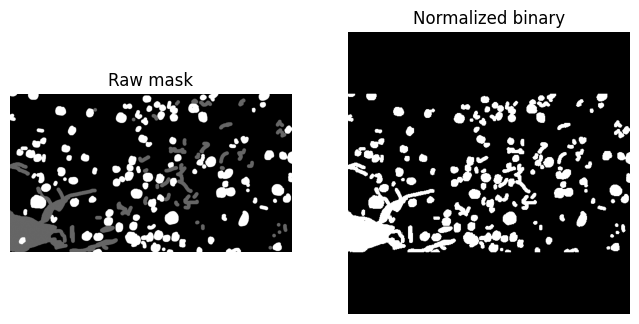

In [ ]:
raw = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/raw/aquavplant/mask/image_0_mask.png")
norm= Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/aquavplant/image_0.png")

arr_raw  = np.array(Image.open(raw))
arr_norm = np.array(Image.open(norm))

print("RAW unique:", np.unique(arr_raw))
print("NORM unique:", np.unique(arr_norm))

# visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(arr_raw, cmap="gray"); plt.title("Raw mask"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(arr_norm, cmap="gray"); plt.title("Normalized binary"); plt.axis("off")
plt.show()

Normalize Bangladesh Data

In [ ]:
from pathlib import Path
from PIL import Image, ImageFile
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

RAW  = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/raw/bangladesh/augmented")
INT  = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented")
INT.mkdir(parents=True, exist_ok=True)

SIZE = 512
def to_square(img: Image.Image, size=512, is_mask=False) -> Image.Image:
    resample = Image.NEAREST if is_mask else Image.BILINEAR
    w, h = img.size
    ratio = min(size / max(w,1), size / max(h,1))
    nw, nh = max(1,int(w*ratio)), max(1,int(h*ratio))
    img = img.resize((nw, nh), resample=resample)
    bg = Image.new("L" if is_mask else "RGB", (size, size), 0 if is_mask else (128,128,128))
    bg.paste(img, ((size-nw)//2, (size-nh)//2))
    return bg

exts = (".jpg",".jpeg",".png",".JPG",".PNG")
bad = []
total_written = 0

classes = [d for d in RAW.iterdir() if d.is_dir()]
for cls in classes:
    files = [p for p in cls.rglob("*") if p.suffix in exts]
    out_dir = INT/cls.name
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"{cls.name}: {len(files)} files")

    for i, p in enumerate(tqdm(files, desc=f"Normalize {cls.name[:18]}…")):
        try:
            with Image.open(p) as im:
                im = im.convert("RGB")
                im_n = to_square(im, SIZE, is_mask=False)
            im_n.save(out_dir/f"{p.stem}.jpg", quality=90, optimize=True)
            total_written += 1
            if (i+1) % 100 == 0:
                print(f"…{i+1} files in {cls.name}")
        except Exception as e:
            bad.append((str(p), repr(e)))
            # continue to next file

print(f"✅ Wrote {total_written} normalized images to: {INT}")
if bad:
    print(f"⚠️ Skipped {len(bad)} bad files (showing first 10):")
    for b in bad[:10]:
        print(" -", b[0], b[1])

Heartleaf False Pickerelweed (Monochoria korsakowii): 1000 files


Normalize Heartleaf False Pi…:  10%|█         | 101/1000 [00:20<01:52,  8.01it/s]

…100 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  20%|██        | 201/1000 [00:32<01:26,  9.19it/s]

…200 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  30%|███       | 301/1000 [00:46<01:52,  6.23it/s]

…300 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  40%|████      | 402/1000 [00:58<01:06,  9.04it/s]

…400 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  50%|█████     | 502/1000 [01:08<00:49, 10.01it/s]

…500 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  60%|██████    | 601/1000 [01:20<00:42,  9.46it/s]

…600 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  70%|███████   | 701/1000 [01:32<00:40,  7.42it/s]

…700 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  80%|████████  | 802/1000 [01:44<00:19, 10.14it/s]

…800 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…:  90%|█████████ | 901/1000 [01:55<00:09, 10.00it/s]

…900 files in Heartleaf False Pickerelweed (Monochoria korsakowii)


Normalize Heartleaf False Pi…: 100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


…1000 files in Heartleaf False Pickerelweed (Monochoria korsakowii)
Water Lettuce (Pistia stratiotes): 1000 files


Normalize Water Lettuce (Pis…:  10%|█         | 101/1000 [01:08<02:04,  7.22it/s]

…100 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  20%|██        | 201/1000 [01:22<01:39,  8.05it/s]

…200 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  30%|███       | 302/1000 [01:38<01:46,  6.56it/s]

…300 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  40%|████      | 400/1000 [01:54<01:39,  6.04it/s]

…400 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  50%|█████     | 501/1000 [02:08<01:08,  7.25it/s]

…500 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  60%|██████    | 600/1000 [02:23<01:00,  6.65it/s]

…600 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  70%|███████   | 701/1000 [02:36<00:43,  6.95it/s]

…700 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  80%|████████  | 801/1000 [02:50<00:24,  7.99it/s]

…800 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…:  90%|█████████ | 901/1000 [03:06<00:18,  5.23it/s]

…900 files in Water Lettuce (Pistia stratiotes)


Normalize Water Lettuce (Pis…: 100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


…1000 files in Water Lettuce (Pistia stratiotes)
Common Duckweeds (Lemna minor): 1050 files


Normalize Common Duckweeds (…:  10%|▉         | 100/1050 [00:58<04:30,  3.51it/s]

…100 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  19%|█▉        | 202/1050 [01:10<01:32,  9.13it/s]

…200 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  29%|██▊       | 301/1050 [01:26<02:00,  6.19it/s]

…300 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  38%|███▊      | 401/1050 [01:39<00:49, 13.09it/s]

…400 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  48%|████▊     | 501/1050 [01:57<01:08,  8.05it/s]

…500 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  57%|█████▋    | 600/1050 [02:13<01:32,  4.88it/s]

…600 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  67%|██████▋   | 701/1050 [02:29<00:37,  9.26it/s]

…700 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  76%|███████▋  | 801/1050 [02:45<00:32,  7.66it/s]

…800 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  86%|████████▌ | 901/1050 [03:02<00:20,  7.26it/s]

…900 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…:  95%|█████████▌| 1001/1050 [03:17<00:04, 10.14it/s]

…1000 files in Common Duckweeds (Lemna minor)


Normalize Common Duckweeds (…: 100%|██████████| 1050/1050 [03:25<00:00,  5.12it/s]


Common Water Hyacinth (Eichornia crassipes): 1000 files


Normalize Common Water Hyaci…:  10%|█         | 101/1000 [08:10<01:22, 10.93it/s]

…100 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  20%|██        | 201/1000 [08:25<01:24,  9.50it/s]

…200 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  30%|███       | 301/1000 [08:37<01:30,  7.70it/s]

…300 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  40%|████      | 401/1000 [08:53<01:30,  6.61it/s]

…400 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  50%|█████     | 502/1000 [09:08<00:51,  9.74it/s]

…500 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  60%|██████    | 600/1000 [09:19<00:58,  6.88it/s]

…600 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  70%|███████   | 702/1000 [09:32<00:35,  8.37it/s]

…700 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  80%|████████  | 801/1000 [09:47<00:22,  8.73it/s]

…800 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…:  90%|█████████ | 901/1000 [10:02<00:14,  6.89it/s]

…900 files in Common Water Hyacinth (Eichornia crassipes)


Normalize Common Water Hyaci…: 100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s]

…1000 files in Common Water Hyacinth (Eichornia crassipes)
✅ Wrote 4050 normalized images to: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/interim/bangladesh_augmented
